# STOR 120 Take Home Midterm 3

Due: Tuesday, November 21st, at 11:59pm

Directions: The exam is open book, notes, course materials, and internet, BUT if you are found to be submitting the work of other students as your exam submission, an honor code violation will be reported. This could be by communication with others and the sharing of answers and code: during the exam time, with students in other sections of the course, by using the solutions to exams from previous semesters, or online answer tools such as Chegg, CourseHero, ChatGPT, etc. This is a zero tolerance policy and all suspected honor code violations will be reported. Just as with all course assignments, you should submit this exam to Gradescope as a Jupyter Notebook with the ipynb file extension. To receive full credit, you should show and run all of your code used to answer each question. You can and SHOULD use or adapt functions that we have written in class or from the textbook.

**Check your file on Gradescope to ensure that it is the file that you intended to submit!**

## Delhi Weather

The `delhi` table imported below contains daily weather time series data from the city of Delhi from 2013 through 2016. This data was found on [Kaggle](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data) and was originally collected from Weather Underground API.

Variable        | Description
----------------|------------------------------------------------------------------------------
date            | Date in format YYYY/MM/DD
year            | Year of reading
month           | Month of reading
day             | Day of reading
mean_temp       | Mean temperature averaged out from multiple 3-hour intervals in a day (Celsius)
humidity        | Humidity value for the day (units are grams of water vapor per cubic meter volume of air)
wind_speed      | Wind speed measured in kmph.
mean_pressure   | Pressure reading of weather (measure in atm)


In [35]:
# Run this cell to set up your notebook

from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from scipy import stats
from scipy.stats import norm
from scipy.stats import t

delhi = Table.read_table('delhi_weather.csv')
delhi.show(3)

date,year,month,day,mean_temp,humidity,wind_speed,mean_pressure,month_name
2016-01-01,2016,1,1,14.7143,72.2857,1.05714,1021.14,January
2016-01-02,2016,1,2,14,75.875,2.0875,1021,January
2016-01-03,2016,1,3,14.375,74.75,5.1125,1018.5,January


**Question 1.** The [Delhi Tourism](https://www.delhitourism.gov.in/delhitourism/aboutus/seasons_of_delhi.jsp) webpage cites that autumn season in Delhi is from end-September to November. Construct a new table `delhi_autumn` that contains data from the `delhi` table for dates ranging from September 16 through the end of November. Note that the `delhi` data contains data ranging over multiple years.

In [37]:
delhi_autumn = delhi.where('month', are.between(9, 12)).where(
    'date', are.not_between('2013-09-01', '2013-09-16')).where(
    'date', are.not_between('2014-09-01', '2014-09-16')).where(
    'date', are.not_between('2015-09-01', '2015-09-16')).where(
    'date', are.not_between('2016-09-01', '2016-09-16'))
delhi_autumn

date,year,month,day,mean_temp,humidity,wind_speed,mean_pressure,month_name
2013-09-16,2013,9,16,29.6667,60,7.1,1002.33,September
2013-09-17,2013,9,17,29.25,56.5,3.475,1002.88,September
2013-09-18,2013,9,18,29.1429,58.5714,5.55714,1003.14,September
2013-09-19,2013,9,19,29.8,61.6,2.96,1001.8,September
2013-09-20,2013,9,20,28.6667,70,9.58333,1003,September
2013-09-21,2013,9,21,25.2,89,5.18,1003,September
2013-09-22,2013,9,22,28.3333,79.6667,3.08333,1001.67,September
2013-09-23,2013,9,23,30.2857,68,4.5,1001,September
2013-09-24,2013,9,24,30.75,65.75,5.7875,1002.75,September
2013-09-25,2013,9,25,28.5714,75,6.61429,1005.43,September


**Question 2.1.** Construct a scatter plot for the relationship between humidty and mean temperature during the autumn season in Delhi. Include the fit line on this plot, using mean temperature to preduct humidity. 

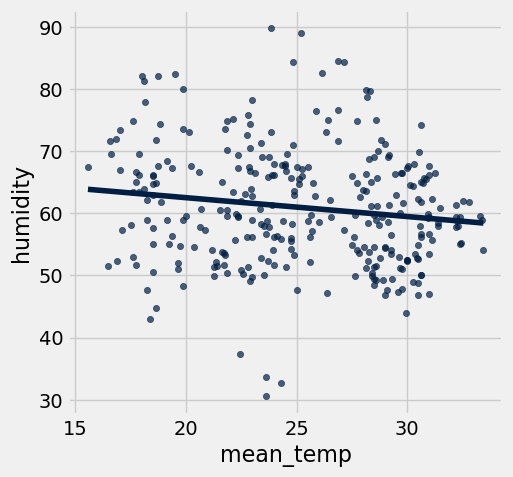

In [38]:
delhi_autumn.scatter('mean_temp', 'humidity', fit_line = True)

**Question 2.2.** Using a least squares regression line (as we have done in class) to predict humidity with mean temperature, what would your model predict would be the average change in humidity for each 3 degree Celsius increase in mean temperature during the autumn season? Assign this value to `change_in_humidity`.

In [52]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def delhi_rmse (any_slope, any_intercept):
    x = delhi_autumn.column('mean_temp')
    y = delhi_autumn.column('humidity')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

def fitted_value(x):
    a = slope(delhi_autumn, 'mean_temp', 'humidity')
    b = intercept(delhi_autumn, 'mean_temp', 'humidity')
    return b + a * x

humidity = make_array()
h_diff = make_array()

for i in np.arange(16, 35, 3):
    n = 0
    prediction = fitted_value(i)
    humidity = np.append(humidity, prediction)
    diff = humidity.item(n) - humidity.item(n - 1)
    h_diff = np.append(h_diff, diff)
    n += 1

change_in_humidity = np.mean(h_diff)
change_in_humidity

2.7359834041545068

**Question 2.3.** Using a least squares regression line (as we have done in class) to predict humidity with mean temperature in autumn, construct a residual plot with the values fitted by the regression model on the horizontal axis and the residuals on the vertical axis. Comment on how the plot shows that the model meets or does not meet the two conditions that we have discussed with residual plots.

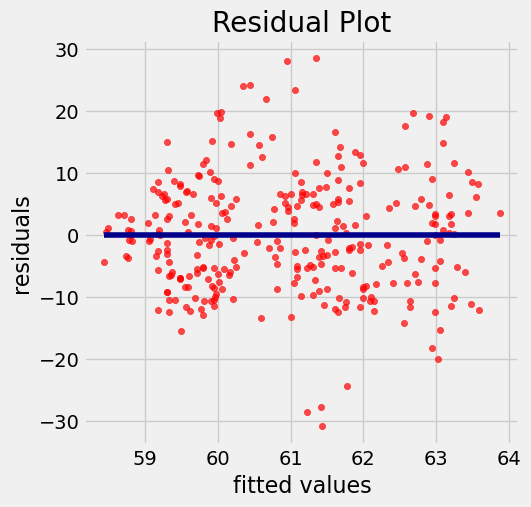

In [54]:
def fitted_values(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fitted_values(table, x, y)

def residual_plot(table, x, y):
    fit = fitted_values(table, x, y)
    t = Table().with_columns(
            'fitted values', fit,
            'residuals', residual(table, x, y)
        )
    t.scatter('fitted values', 'residuals', color='r')
    xlims = make_array(min(fit), max(fit))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

residual_plot(delhi_autumn, 'mean_temp', 'humidity')

*The spread is pretty even, barring some outliers near the -30 mark. I would still say a linear model is appropriate because it is centered around because there is no overall pattern in the curve of the plot.*

**Question 2.4.** Using a least squares regression line (as we have done in class) to predict humidity with mean temperature, construct a 99% prediction interval for the average humidity during autumn for temperatures of 19 degrees Celsius. Assign `interval_bounds` to an array containing the lower and upper bounds of this prediction interval. You should *not* hard code these values and do *not* need to include a plot.

In [56]:
def predict(t, x, y, x_value):
    return slope(t, x, y) * x_value + intercept(t, x, y)

def bootstrap_prediction(t, x, y, new_x, repetitions=1000):

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = predict(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    return make_array(left, right)

interval_bounds = bootstrap_prediction(delhi_autumn, 'mean_temp', 'humidity', 19)
interval_bounds

array([ 61.03790968,  64.60294665])

**Question 3.** Use the full delhi data (from all seasons, not just autumn) to construct a multiple regression linear model (y = ax + bz + c) using using mean temperature and wind speed to predict humidity. You should do this by determining the coefficients for your model that minimze the root mean squared errors **using the methods from class**. Use this model to predict the average humidity for days with a mean temperature of 19 degrees Celsius and mean wind speed of 7.2 kilometers per hour. Assign this value to `mult_mod_prediction`. Note that you do *not* need to construct a prediction interval. 

In [58]:
def multiple_regression_rmse(mean_temp_mult, wind_speed_mult, intercept):
    
    mean_temp = delhi.column('mean_temp')
    wind_speed = delhi.column('wind_speed')
    
    y = delhi.column('humidity')
    
    prediction = sum([
        mean_temp_mult * mean_temp,
        wind_speed_mult * wind_speed,
        intercept]
    )
    
    mse = np.mean((y - prediction) ** 2)
    return np.sqrt(mse)

coeff = minimize(multiple_regression_rmse)

mult_mod_prediction = coeff.item(0) * 19 + coeff.item(1) * 7.2 + coeff.item(2)
mult_mod_prediction

67.86445002903675

**Question 4.1** The [Delhi Tourism](https://www.delhitourism.gov.in/delhitourism/aboutus/seasons_of_delhi.jsp) webpage cites that the spring season in Delhi is from February through March and the winter season is from December through January. Assign `spring_wind_mean` and `winter_wind_mean` to the mean wind speeds for data from Delhi during the spring and winter seasons (respectively)

In [61]:
spring_wind_mean = np.mean(delhi.where('month', are.between(2, 4)).column('wind_speed'))
winter_wind_mean = np.mean(delhi.where('month', 1 and 12).column('wind_speed'))

spring_wind_mean, winter_wind_mean

(7.1409935575441912, 4.7619637151252086)

**Question 4.2** Assign `spring_wind_sd` and `winter_wind_sd` to the standard deviation of the wind speed for data from Delhi during the spring and winter seasons (respectively).

In [62]:
spring_wind_sd = np.std(delhi.where('month', are.between(2, 4)).column('wind_speed'))
winter_wind_sd = np.std(delhi.where('month', 1 and 12).column('wind_speed'))

spring_wind_sd, winter_wind_sd

(3.8789497954592309, 4.3398751259485202)

**Question 4.3** Assign `spring_wind_n` and `winter_wind_n` to the number of wind speed observations for data from Delhi during the spring and winter seasons (respectively).

In [63]:
spring_wind_n = delhi.where('month', are.between(2, 4)).num_rows
winter_wind_n = delhi.where('month', 1 and 12).num_rows

spring_wind_n, winter_wind_n

(237, 124)

**Question 4.4** Perfom a hypothesis test using the hypotheses below:

**Null Hypothesis:** Mean wind speeds during the winter season are equal to the mean wind speeds during the spring season

**Alternative Hypothesis:** Mean wind speeds during the winter season are less than the mean winds speed during the spring season

Rather than perform a simulation for this hypothesis test, you should use methods covered in lectures 24 through 27, using the normal or t distribution (whichever is appropriate for the situation), and using your answers to questions 4.1, 4.2, and 4.3. Assign the p-value for your hypothesis test to `p_value` and cite your conclusions to the hypothesis test.

Zero points will be given for performing a simulation or using methods outside those covered in the course. You do *not* need to produce a plot.

In [70]:
obs_diff = spring_wind_mean - winter_wind_mean
z_score = (obs_diff - 0) / winter_wind_sd

In [71]:
p_value = norm.cdf(obs_diff, 0, winter_wind_sd)
p_value

0.70821561352714202

*The p-value is high, so we fail to reject the null hypothesis. Therefore, the mean wind speed are equal during the winter and spring seasons.*